In [46]:
%matplotlib inline
from pylab import *
import random as rnd
import networkx as nx
from __future__ import division


def draw_graph(graph, labels=None, graph_layout='shell',
               node_size=3200, node_color='blue', node_alpha=0.3,
               node_text_size=24,
               edge_color='blue', edge_alpha=0.3, edge_tickness=2,
               edge_text_pos=0.6,
               text_font='sans-serif'):
    """ 
    Based on: https://www.udacity.com/wiki/creating-network-graphs-with-python
    We describe a graph as a list enumerating all edges.
    Ex: graph = [(1,2), (2,3)] represents a graph with 2 edges - (node1 - node2) and (node2 - node3)
    """
    rcParams['figure.figsize'] = 24, 24 # that's default image size for this interactive session
    
    # these are different layouts for the network you may try
    # shell seems to work best
    if graph_layout == 'spring':
        graph_pos=nx.spring_layout(graph)
    elif graph_layout == 'spectral':
        graph_pos=nx.spectral_layout(graph)
    elif graph_layout == 'random':
        graph_pos=nx.random_layout(graph)
    else:
        graph_pos=nx.shell_layout(graph)

    # draw graph
    nx.draw_networkx_nodes(graph,graph_pos,node_size=node_size, 
                           alpha=node_alpha, node_color=node_color)
    nx.draw_networkx_edges(graph,graph_pos,width=edge_tickness,
                           alpha=edge_alpha,edge_color=edge_color)
    nx.draw_networkx_labels(graph, graph_pos,font_size=node_text_size,
                            font_family=text_font)
    # show graph
    plt.show()

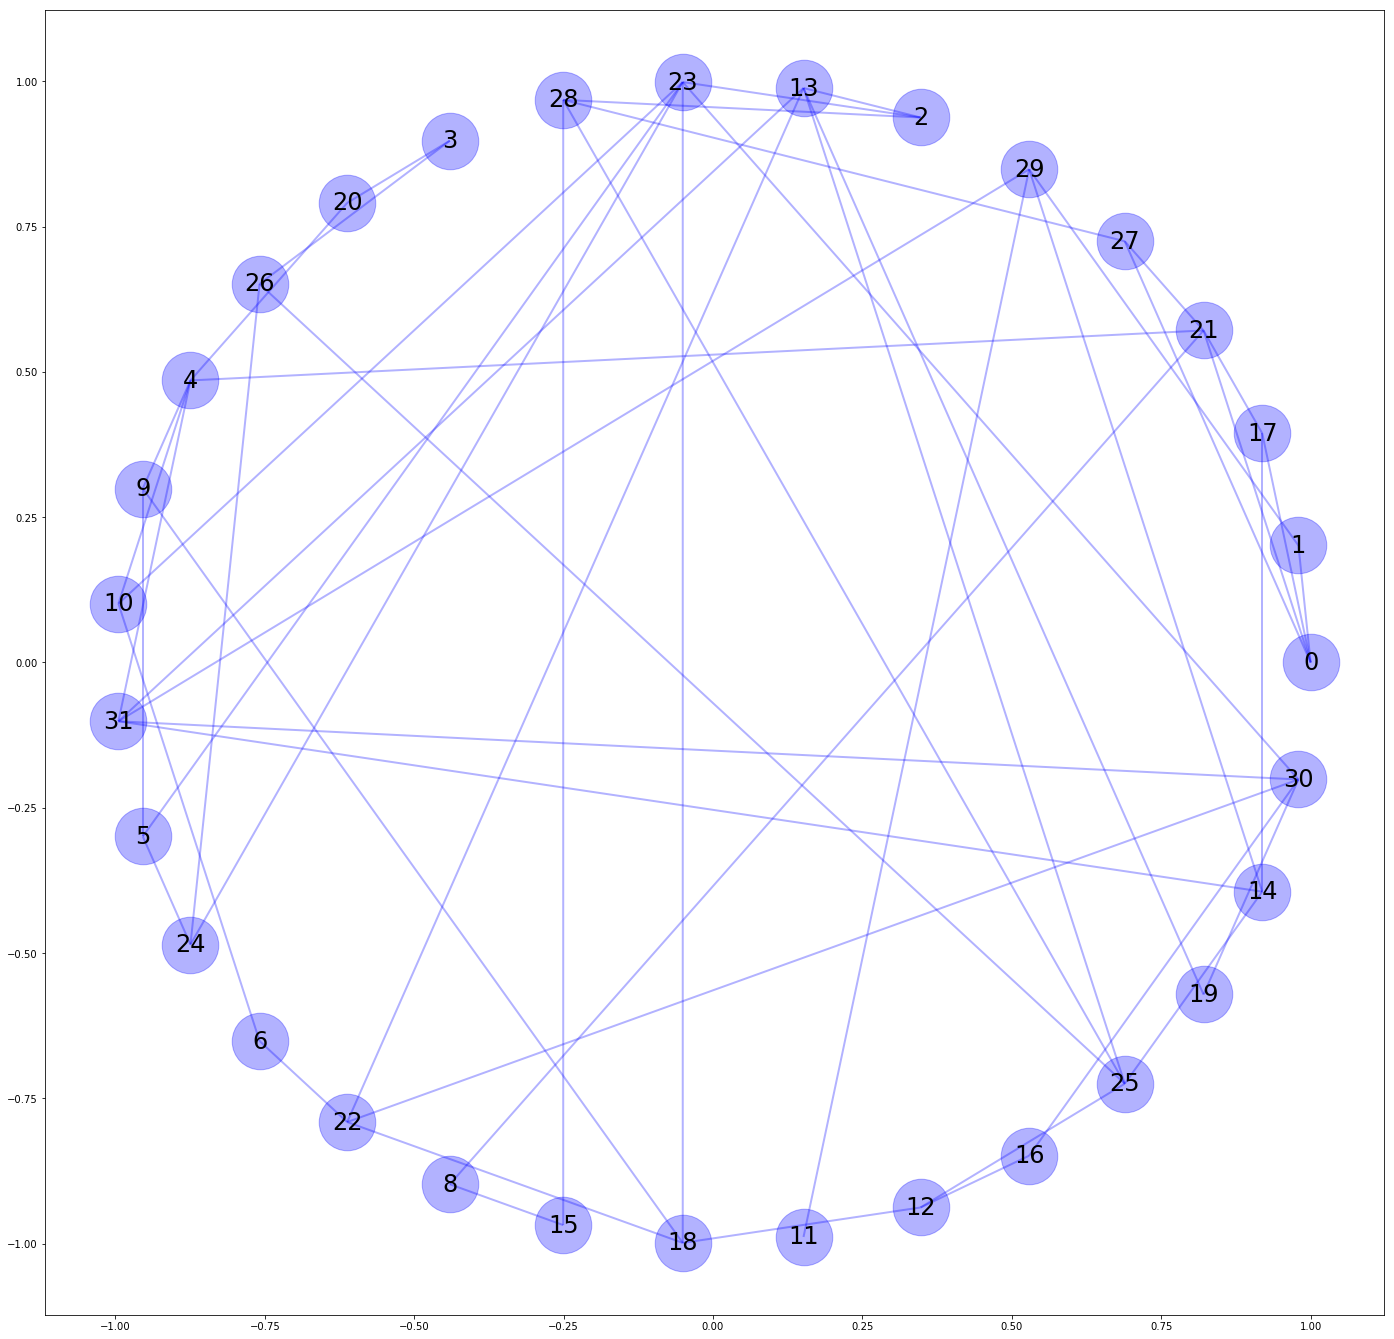

In [47]:
#seed = rnd.getrandbits(64)
#print('Seed = {}'.format(seed))
#rnd.seed(seed)
rnd.seed(11342731407549461295)
TOTAL_V = 32
p = 0.1
G = nx.Graph()
G.add_edges_from([(x, y) for x in range(TOTAL_V) for y in range(x, TOTAL_V) if rnd.random() < p])
draw_graph(G)

In [48]:
rowdy = set()
for k, v in G.adj.items():
    l = list(v.keys())
    for i in range(len(l)-1):
        for j in range(i+1, len(l)):
            if k in G.adj[l[i]] and k in G.adj[l[j]] and l[i] in G.adj[l[j]] and k != l[i] and k != l[j]:
                rowdy.add(frozenset([k, l[i], l[j]]))

{3, 4, 5, 6, 9, 10, 12, 16, 18, 20, 22, 23, 24, 26, 30}
{0, 1, 2, 8, 11, 13, 14, 15, 17, 19, 21, 25, 27, 28, 29, 31}


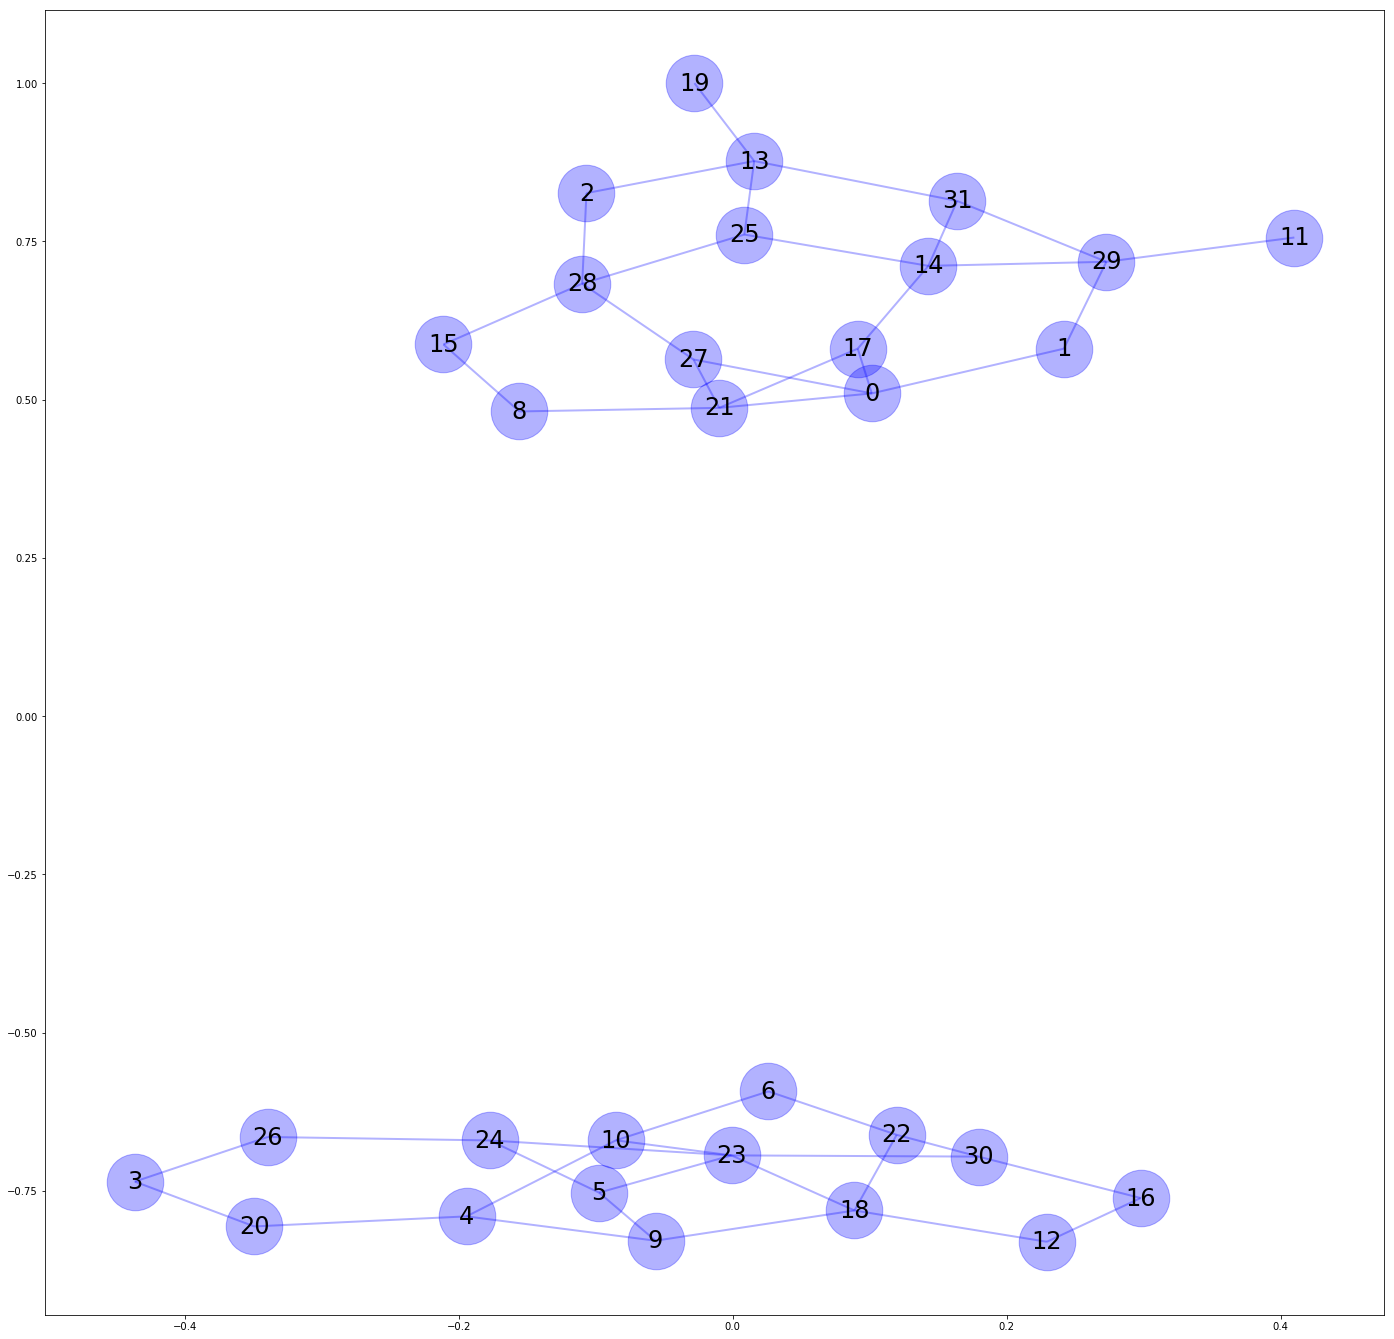

In [49]:
from networkx.algorithms.community.kernighan_lin import kernighan_lin_bisection as kl_bisect
sub0, sub1 = kl_bisect(G, weight=None, seed=rnd.getrandbits(32))
print(sub0)
print(sub1)
sub0, sub1 = G.subgraph(sub0), G.subgraph(sub1)
split = nx.compose(sub0, sub1)
draw_graph(split, graph_layout='spring')

{3, 4, 5, 9, 20, 24, 26}
{6, 10, 12, 16, 18, 22, 23, 30}


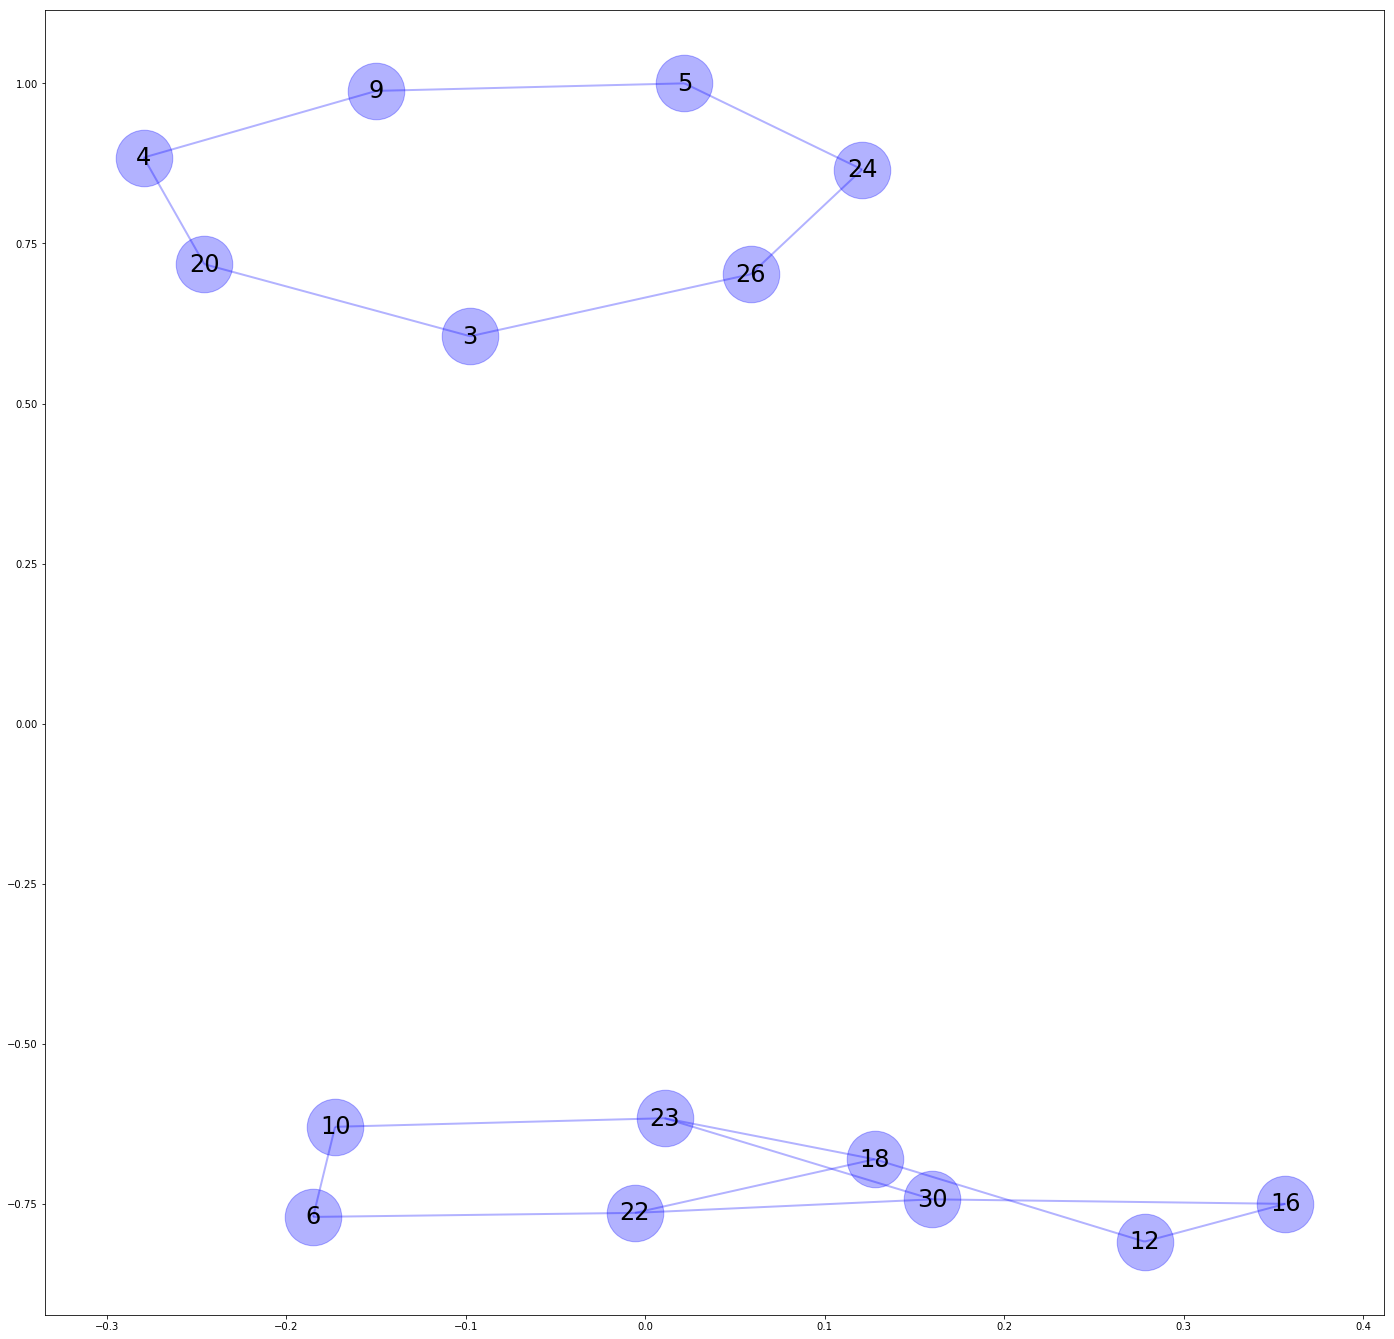

In [50]:
sub00, sub01 = kl_bisect(sub0, weight=None, seed=rnd.getrandbits(32))
sub10, sub11 = kl_bisect(sub1, weight=None, seed=rnd.getrandbits(32))
print(sub00)
print(sub01)
sub00, sub01 = G.subgraph(sub00), G.subgraph(sub01)
split0 = nx.compose(sub00, sub01)
draw_graph(split0, graph_layout='spring')

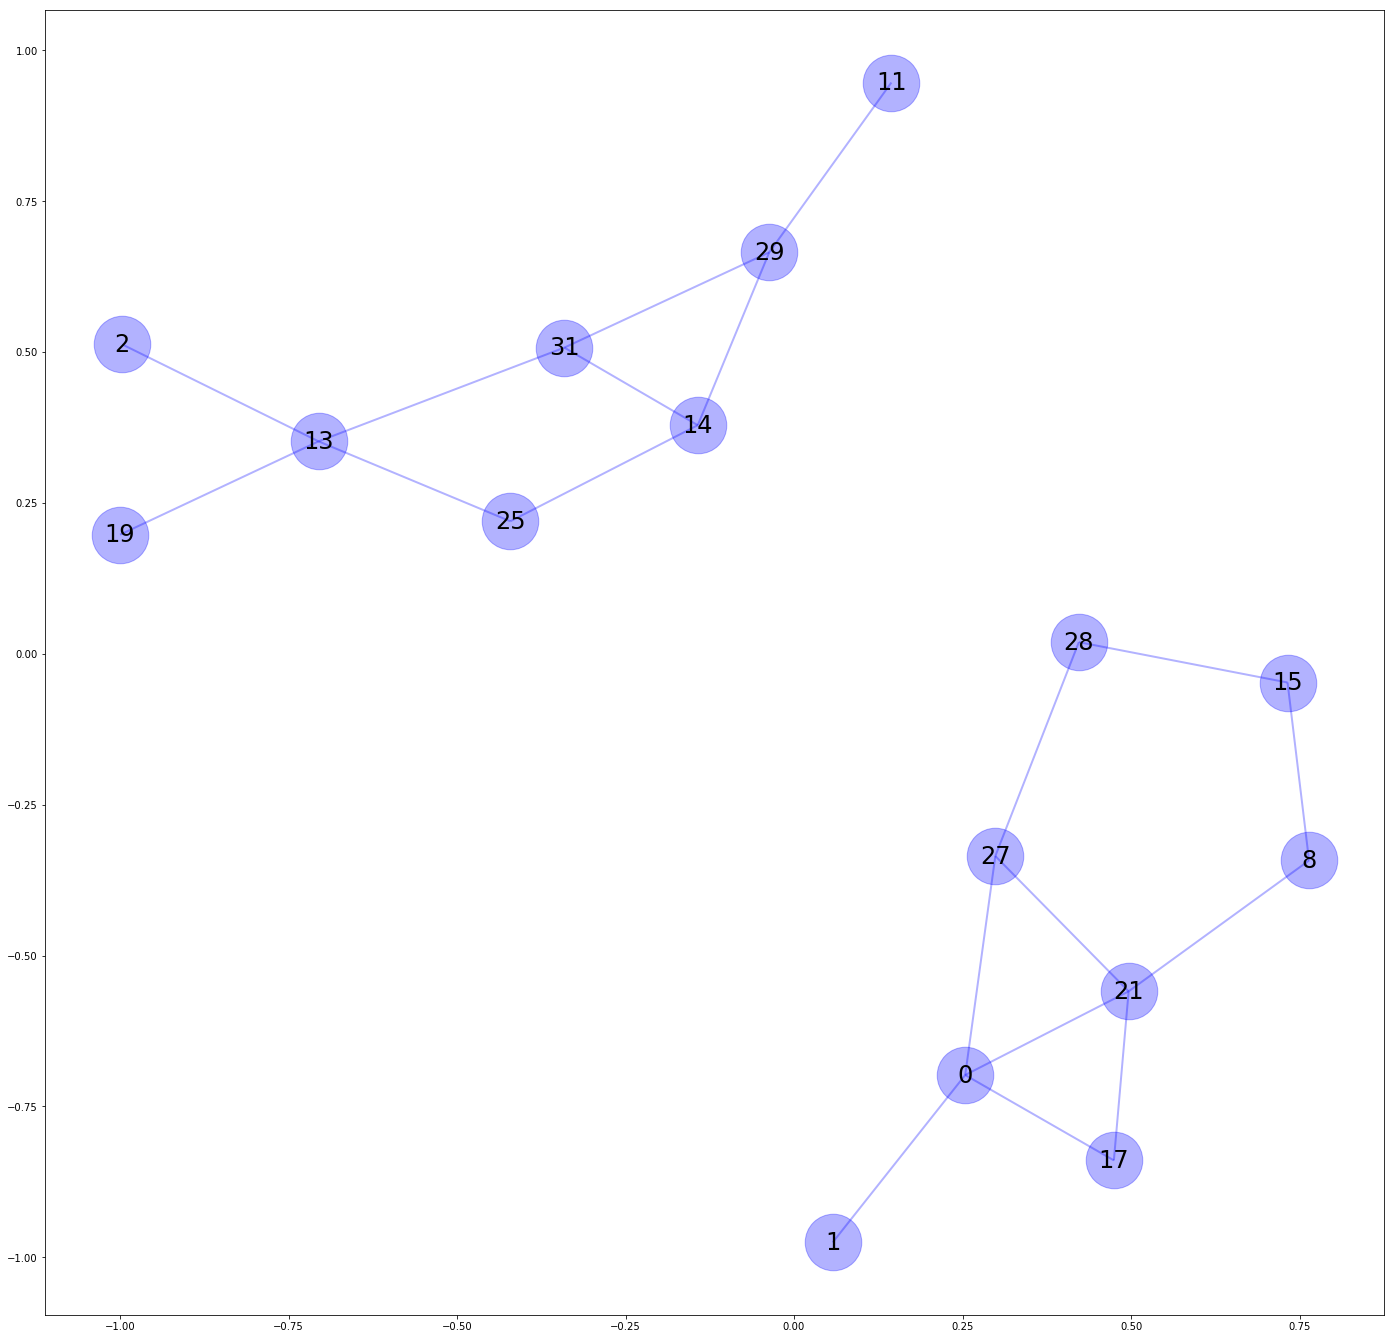

In [51]:
sub10, sub11 = G.subgraph(sub10), G.subgraph(sub11)
print(sub10)
print(sub11)
split1 = nx.compose(sub10, sub11)
draw_graph(split1, graph_layout='spring')

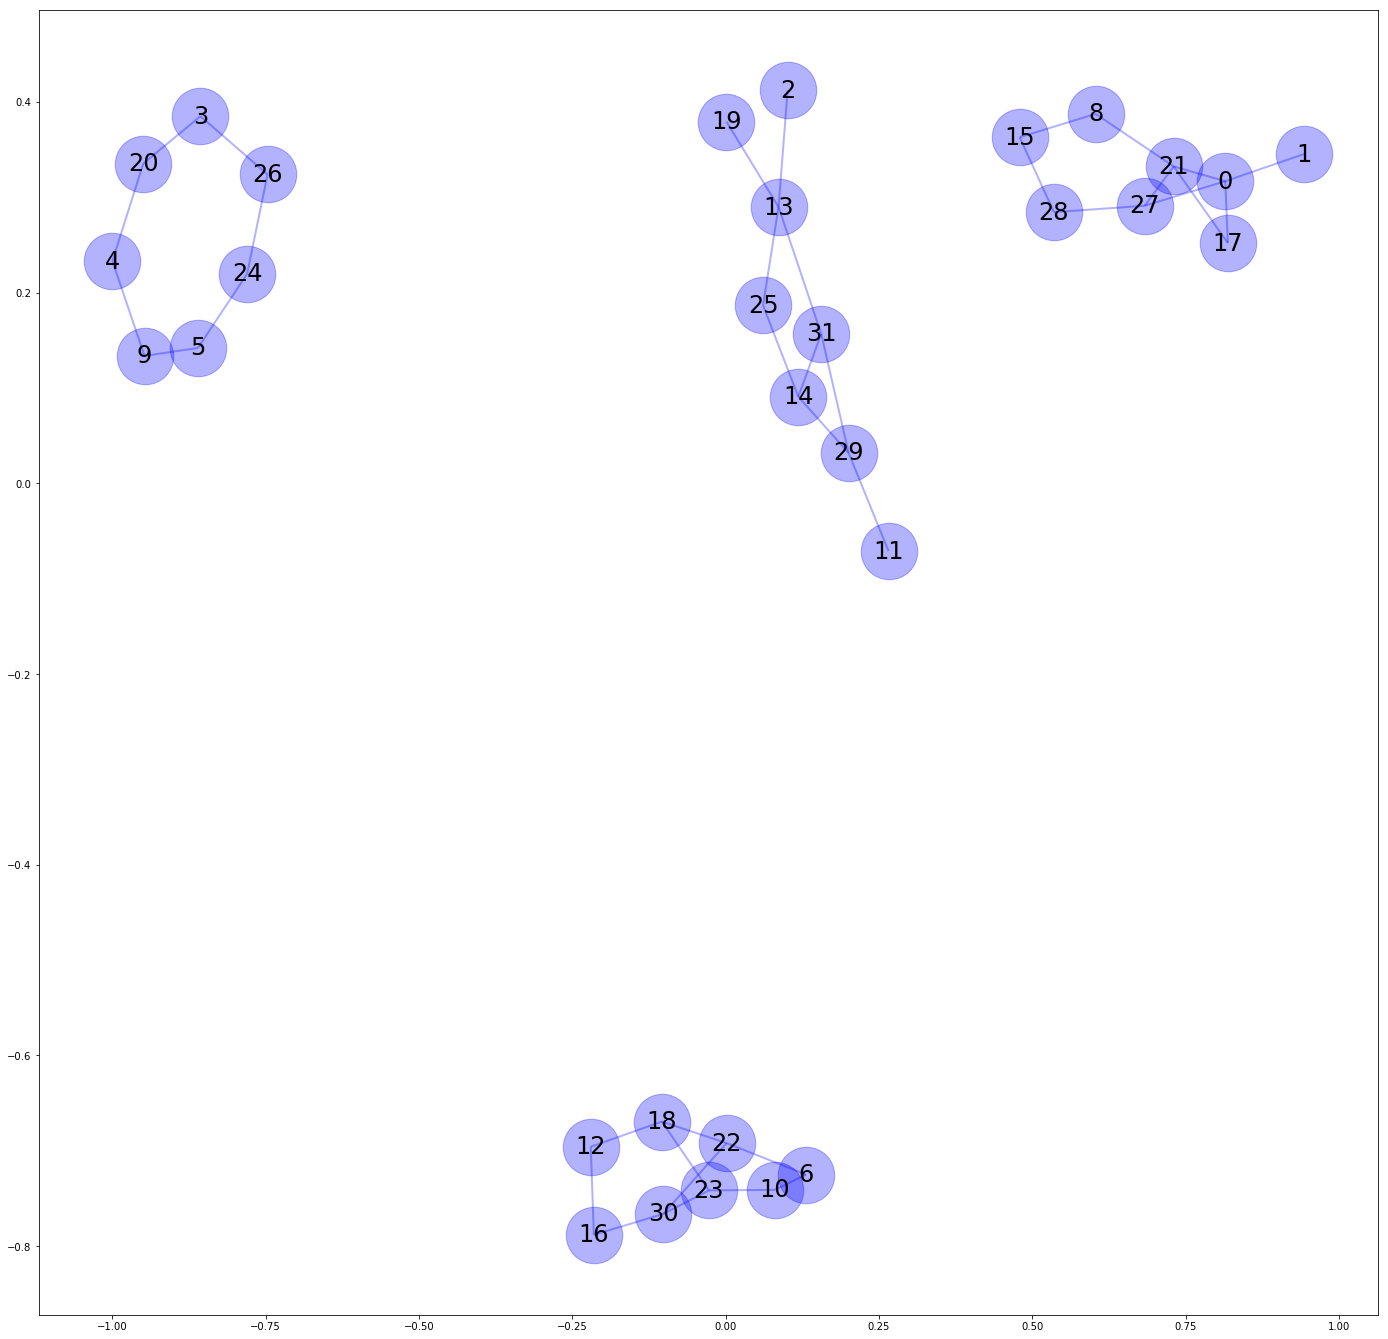

In [52]:
split = nx.compose(split0, split1)
draw_graph(split, graph_layout='spring')